In [1]:
import os
import json
base_path = "/datasets/mvtec"

train_file = f"{base_path}/mvtec_screws_train.json"
val_file = f"{base_path}/mvtec_screws_val.json"
test_file = f"{base_path}/mvtec_screws_test.json"
category_names = {7:'nut', 3:'wood_screw', 2:'lag_wood_screw', 8:'bolt',
                  6:'black_oxide_screw', 5:'shiny_screw', 4:'short_wood_screw',
                  1:'long_lag_screw', 9:'large_nut', 11:'nut2', 10:'nut1',
                  12:'machine_screw', 13:'short_machine_screw' }

import numpy as np

def get_xywha_for_write(file):
    label_file = json.load(open(file, "r"))
    
    image_name_lines = {}
    image_id_names = {}
    for img in label_file["images"]:
        image_name_lines[img["file_name"]] = []
        image_id_names[img["id"]] = img["file_name"]
    
    for ant in label_file["annotations"]:
        category_id = ant["category_id"]
        image_id = ant["image_id"]
        ant_id = ant["id"]
        
        # cx, cy가 아닌 cy, cx로 레이블링 되어있음
        cy, cx, w, h, a = ant["bbox"]
        
        # angle은 (-π, π] 라고 했는데, 해당 범위를 넘어가는 데이터가 존재하므로 
        # (-π, π] 범위로 재조정
        if a < 0:
            a += 2 * np.pi
        
        assert 0 <= a < 2 * np.pi  # Ensure t is in the range [0, 2π)

        a = np.rad2deg(a) # degree로 변환
        if np.isclose(a, 360, atol=0.5):
            a = 0

        label = category_names[category_id]
        
        # (obb) + (label) + (difficulty)
        line = "%d %d %d %d %f %s %d" % (cx, cy, w, h, a, label, 0)
        image_name_lines[image_id_names[image_id]].append(line)
    return image_name_lines

train_image_name_lines = get_xywha_for_write(train_file)
val_image_name_lines = get_xywha_for_write(val_file)
test_image_name_lines = get_xywha_for_write(test_file)



In [26]:
def write_to_labels(image_name_lines):
    os.makedirs(f"{base_path}/annfiles", exist_ok=True)
    for image_name, lines in image_name_lines.items():
        txt_path = os.path.join(f"{base_path}/annfiles", image_name.rstrip(".png")+".txt")
        with open(txt_path, "w") as f:
            for line in lines:
                f.writelines(line + "\n")
write_to_labels(train_image_name_lines)
write_to_labels(val_image_name_lines)
write_to_labels(test_image_name_lines)   

In [2]:
import glob 
import shutil

anns_path = f"{base_path}/annfiles"
imgs_path = f"{base_path}/images"
trainval_path = f"{base_path}/trainval"
test_path = f"{base_path}/test"
import os
trainval_imgs_path = os.path.join(trainval_path, "images")
trainval_anns_path = os.path.join(trainval_path, "annfiles")
test_imgs_path = os.path.join(test_path, "images")
test_anns_path = os.path.join(test_path, "annfiles")

os.makedirs(trainval_imgs_path, exist_ok=True)
os.makedirs(trainval_anns_path, exist_ok=True)
os.makedirs(test_imgs_path, exist_ok=True)
os.makedirs(test_anns_path, exist_ok=True)

txtfiles = glob.glob(f"{base_path}/annfiles/*.txt")
import random
random.shuffle(txtfiles)
imgfiles = [txtfile.replace("annfiles", "images").replace(".txt", ".png") for txtfile in txtfiles]
if not os.path.isfile(imgfiles[0]):
    imgfiles = [txtfile.replace("annfiles", "images").replace(".txt", ".jpg") for txtfile in txtfiles]
    print(imgfiles[0])
    assert os.path.isfile(imgfiles[0])

n = len(txtfiles)
n_train = int(n*0.8)

In [3]:
train_txtfiles = txtfiles[:n_train]
train_imgfiles = imgfiles[:n_train]

for train_txtfile, train_imgfile in zip(train_txtfiles, train_imgfiles):
    txtfilename = train_txtfile.split("/")[-1]
    imgfilename = train_imgfile.split("/")[-1]
    shutil.copy(train_txtfile, os.path.join(trainval_anns_path, txtfilename))
    shutil.copy(train_imgfile, os.path.join(trainval_imgs_path, imgfilename))
    
test_txtfiles = txtfiles[n_train:]
test_imgfiles = imgfiles[n_train:]

for test_txtfile, test_imgfile in zip(test_txtfiles, test_imgfiles):
    txtfilename = test_txtfile.split("/")[-1]
    imgfilename = test_imgfile.split("/")[-1]
    shutil.copy(test_txtfile, os.path.join(test_anns_path, txtfilename))
    shutil.copy(test_imgfile, os.path.join(test_imgs_path, imgfilename))

In [45]:
import sys
sys.path.append("..")
from datasets.detdemo import DetDemoDataset
data = DetDemoDataset(
    "/workspace/datasets/detdemo.pth", 
    base_path, 
    split="train"
)

[DATA] /workspace/datasets/detdemo.pth not found, creating...


Loading annotations: 100%|██████████| 15/15 [00:00<00:00, 6356.29it/s]


In [ ]:
angles = []
for image, target in data:
    obox = target['oboxes']
    angle = obox[:, -1]
    angles.extend(angle.tolist())

(array([26.,  7.,  6.,  3.,  1.,  2.,  2.,  2.,  1.,  0.,  0.,  0.,  1.,
         0.,  0.,  3.,  2.,  6.,  6.,  1.,  3.,  3.,  1.,  4.,  0.,  7.,
         4.,  3.,  1.,  3.,  1.,  4.,  4.,  2.,  0.,  1.,  1.,  4.,  2.,
         3.,  2.,  0.,  1.,  3.,  2.,  4.,  6.,  3.,  5.,  4., 18.,  7.,
         5.,  4.,  4.,  2.,  0.,  3.,  4.,  2.,  4.,  2.,  2.,  3.,  1.,
         0.,  5.,  4.,  6.,  2.,  4.,  3.,  7.,  5.,  3., 14.,  5.,  4.,
         8.,  2.,  2.,  2.,  3.,  4.,  0.,  0.,  2.,  1.,  2.,  2.,  2.,
         1.,  2.,  7.,  3.,  2.,  3.,  7., 10., 15.]),
 array([  0.        ,   3.58899994,   7.17799988,  10.76699982,
         14.35599976,  17.94499969,  21.53399963,  25.12299957,
         28.71199951,  32.30099945,  35.88999939,  39.47899933,
         43.06799927,  46.65699921,  50.24599915,  53.83499908,
         57.42399902,  61.01299896,  64.6019989 ,  68.19099884,
         71.77999878,  75.36899872,  78.95799866,  82.5469986 ,
         86.13599854,  89.72499847,  93.31399841, 

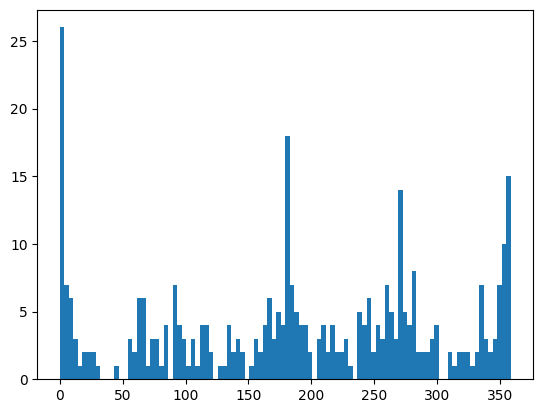

In [ ]:
import matplotlib.pyplot as plt
plt.hist(angles, bins=100)

In [ ]:
from torchvision.transforms.functional import to_pil_image
os.makedirs("/datasets/mvtec/rrois/train", exist_ok=True)
for tensor_image, target in data:
    oboxes, polys = target["oboxes"], target["polygons"]
    image_path = target["image_path"]
    image_name = image_path.split("/")[-1].split(".")[0]

    # use image as feature
    feature = {"0": tensor_image.unsqueeze(0)}
    from ops.poolers import MultiScaleRotatedRoIAlign
    rroi_align = MultiScaleRotatedRoIAlign(["0"], output_size = 200, sampling_ratio=2, canonical_scale=224, canonical_level=4)
    rrois = rroi_align(feature, [oboxes], image_shapes=[[1920, 1440]])
    pil_rrois = list(map(to_pil_image, rrois))
    for i, (obox, poly, pil_rroi) in enumerate(zip(oboxes, polys, pil_rrois)):
        obox_imagename = str(obox.tolist()) + "_" + image_name + ".png"
        pil_rroi.save(os.path.join("/datasets/mvtec/rrois/train", obox_imagename))

KeyboardInterrupt: 

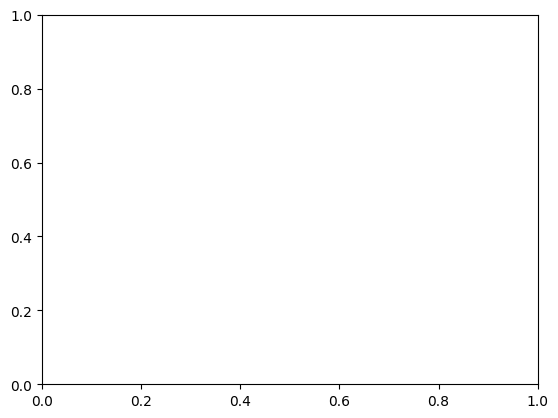

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
phi = np.linspace(0, 360, 1000)
phi_star = phi.copy()

d_phi = lambda a, b: a-b if np.abs(a-b) < 180 else a-b-360 *np.sign(a-b)
data = []

for p in phi:
    for ps in phi_star:
        d = d_phi(p, ps)
        data.append(d)
plt.hist(data, bins=100)

In [ ]:
import torch
x, y = 0.8, 0.8
x /= torch.norm(torch.tensor([x, y]))
y /= torch.norm(torch.tensor([x, y]))
a = torch.rad2deg(torch.atan2(torch.tensor([x]), torch.tensor([y])))

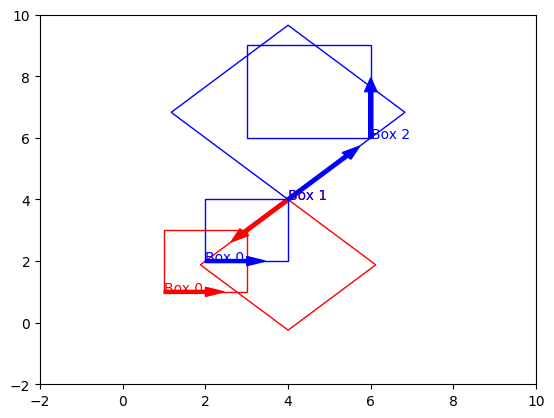

Boxes1 0 vs Boxes2 0: 0.1428571492433548
Boxes1 0 vs Boxes2 1: 0.0
Boxes1 0 vs Boxes2 2: 0.0
Boxes1 1 vs Boxes2 0: 0.0005664207274094224
Boxes1 1 vs Boxes2 1: 0.5624999403953552
Boxes1 1 vs Boxes2 2: 0.03619065880775452
tensor([[0.1429, 0.0000, 0.0000],
        [0.0006, 0.5625, 0.0362]])


In [ ]:
# Import necessary modules
import numpy as np
import torch
from detectron2._C import box_iou_rotated
# Create test tensors
boxes1 = torch.tensor([[1, 1, 2, 2, 0], [4, 4, 3, 3, 225]]).float()
boxes2 = torch.tensor([[2, 2, 2, 2, 0], [4, 4, 4, 4, 45], [6, 6, 3, 3, 90]]).float()
import matplotlib.pyplot as plt


# Plot the boxes
fig, ax = plt.subplots()
for i, box in enumerate(boxes1):
    rect = plt.Rectangle((box[0], box[1]), box[2], box[3], angle=box[4], edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    # Add arrow to indicate direction
    arrow_length = 0.5 * max(box[2], box[3])
    arrow_dx = arrow_length * np.cos(np.deg2rad(box[4]))
    arrow_dy = arrow_length * np.sin(np.deg2rad(box[4]))
    ax.arrow(box[0], box[1], arrow_dx, arrow_dy, color='r', width=0.1)
    ax.text(box[0], box[1], f'Box {i}', color='r')
    
for i, box in enumerate(boxes2):
    rect = plt.Rectangle((box[0], box[1]), box[2], box[3], angle=box[4], edgecolor='b', facecolor='none')
    ax.add_patch(rect)
    # Add arrow to indicate direction
    arrow_length = 0.5 * max(box[2], box[3])
    arrow_dx = arrow_length * np.cos(np.deg2rad(box[4]))
    arrow_dy = arrow_length * np.sin(np.deg2rad(box[4]))
    ax.arrow(box[0], box[1], arrow_dx, arrow_dy, color='b', width=0.1)
    ax.text(box[0], box[1], f'Box {i}', color='b')
# Set plot limits
ax.set_xlim(-2, 10)
ax.set_ylim(-2, 10)

# Show the plot
plt.show()

# Calculate IoU
iou = box_iou_rotated(boxes1, boxes2, False)
for i in range(len(iou)):
    for j in range(len(iou[i])):
        print(f'Boxes1 {i} vs Boxes2 {j}: {iou[i][j]}')

# Print the result
print(iou)

In [ ]:
import torch
from shapely.geometry import Polygon
from shapely.affinity import rotate, translate

def rect_to_polygon(rect):
    cx, cy, w, h, angle = rect
    # Rectangle centered at origin
    rect = Polygon([(-w/2, -h/2), (-w/2, h/2), (w/2, h/2), (w/2, -h/2)])
    # Rotate and translate the rectangle
    rotated = rotate(rect, angle, origin=(0, 0), use_radians=False)
    translated = translate(rotate(rotated, angle, 'center'),cx, cy)
    return translated

def calculate_iou(poly1, poly2):
    intersection = poly1.intersection(poly2).area
    union = poly1.union(poly2).area
    return intersection / union

# Convert tensors to numpy arrays
boxes1_np = boxes1.numpy()
boxes2_np = boxes2.numpy()

# Convert numpy arrays to polygons
polygons1 = [rect_to_polygon(rect) for rect in boxes1_np]
polygons2 = [rect_to_polygon(rect) for rect in boxes2_np]

# Calculate IoUs
ious = []
for i, poly1 in enumerate(polygons1):
    t = []
    for j, poly2 in enumerate(polygons2):
        iou = calculate_iou(poly1, poly2)
        t.append(iou)
    ious.append(t)

# ious now contains the IoU for each pair of rectangles
print(np.array(ious))


[[0.14285714 0.         0.        ]
 [0.01960784 0.5625     0.05882353]]


In [ ]:
import glob
import math
from xml.etree import ElementTree as ET
from statistics import mean

# Function to rotate a point anticlockwise around an origin
def rotate_point(x, y, angle_degrees, origin):
    angle_radians = math.radians(-angle_degrees)
    ox, oy = origin
    qx = ox + math.cos(angle_radians) * (x - ox) + math.sin(angle_radians) * (y - oy)
    qy = oy - math.sin(angle_radians) * (x - ox) + math.cos(angle_radians) * (y - oy)
    return qx, qy

def parse_labelme_anns(base_path):
    xml_files_list = glob.glob(base_path + "/*.xml")
    # Initialize an empty dictionary to store all parsed details from multiple files
    all_files_details = {}

    # Loop through each XML data string in the list
    for xml_path in xml_files_list:
        with open(xml_path, 'r') as f:
            xml_data = f.read()
        
        # Parse XML data
        root = ET.fromstring(xml_data)
        
        # Get the filename
        filename = root.find('filename').text if root.find('filename') is not None else 'Unknown'
            
        # Initialize an empty list to store object details for this file
        file_object_details = []
        
        # Loop through each object in the XML
        for obj in root.findall('object'):
            # Check if the object has a name and a polygon
            if obj.find('name') is not None and obj.find('polygon') is not None:
                name = obj.find('name').text  # Get the class label/name
                polygon = obj.find('polygon')  # Get the polygon element
                coordinates = []  # Initialize an empty list to store coordinates
                
                # Get the rotation angle from attributes (default to 0 if not found)
                rotation_angle = float(obj.find('attributes').text.split('=')[-1]) if obj.find('attributes') is not None else 0.0
                
                # Loop through each point in the polygon
                for pt in polygon.findall('pt'):
                    x = float(pt.find('x').text)  # Get the x-coordinate and convert to float
                    y = float(pt.find('y').text)  # Get the y-coordinate and convert to float
                    coordinates.append((x, y))  # Append the (x, y) tuple to the coordinates list

                # Calculate the center of the polygon
                center_x = mean(x for x, y in coordinates)
                center_y = mean(y for x, y in coordinates)
                    
                # Rotate the coordinates around the center
                rotated_coordinates = [rotate_point(x, y, rotation_angle, (center_x, center_y)) for x, y in coordinates]
                x1, y1 = coordinates[0]
                x2, y2 = coordinates[1]
                x3, y3 = coordinates[2]
                x4, y4 = coordinates[3]

                w, h = math.sqrt((x1-x2)**2 + (y1-y2)**2), math.sqrt((x2-x3)**2 + (y2-y3)**2)
                file_object_details.append({
                    'name': name,
                    'coordinates': rotated_coordinates,
                    'cxcywht': (center_x, center_y, w, h, 360-rotation_angle), # (cx, cy, w, h, theta)
                    'rotation': rotation_angle
                })
        
        # Add this file's object details to the all_files_details dictionary
        all_files_details[filename] = file_object_details
    return all_files_details
train_files_details = parse_labelme_anns("/datasets/labelme_detdemo/default")
test_files_details = parse_labelme_anns("/datasets/labelme_detdemo/default")

In [ ]:
image_name_lines = {}
all_files_details = {**train_files_details, **test_files_details}
for filename, labels in all_files_details.items():
    lines = []
    for label in labels:
        cx, cy, w, h, a = label['cxcywht']
        class_label = label['name']
        line = "%d %d %d %d %f %s %d" % (cx, cy, w, h, a, class_label, 0)
        lines.append(line)
    image_name_lines.setdefault(filename, []).extend(lines)

In [32]:
base_path = "/datasets/detdemo"
def write_to_labels(image_name_lines):
    os.makedirs(f"{base_path}/annfiles", exist_ok=True)
    for image_name, lines in image_name_lines.items():
        txt_path = os.path.join(f"{base_path}/annfiles", image_name.rstrip(".jpg")+".txt")
        with open(txt_path, "w") as f:
            for line in lines:
                f.writelines(line + "\n")

In [33]:
import os
write_to_labels(image_name_lines)

NameError: name 'image_name_lines' is not defined

In [34]:
import glob
annfiles = glob.glob(f"{base_path}/annfiles/*.txt")
images = [annfile.replace("annfiles", "images").replace(".txt", ".jpg") for annfile in annfiles]

In [ ]:
from IPython.display import display
from PIL import Image
import shutil
import os
import torch
from torchvision.io import read_image
from visualize_utils import plot_image
from datasets.detdemo import DetDemoDataset
# os.makedirs(f"{base_path}/annfiles_removed", exist_ok=True)
for annfile, image in zip(annfiles, images):
    lines=open(annfile, "r").readlines()
    boxes = []
    labels = []
    print(annfile)
    for line in lines:
        x, y, w, h, a, label, _ = line.split()
        boxes.append([float(x), float(y), float(w), float(h), float(a)])
        labels.append(DetDemoDataset.class_to_idx(label))
    

    boxes = torch.tensor(boxes)
    labels = torch.tensor(labels)

    image_pil, _ = plot_image(read_image(image), {}, {"oboxes": boxes, "labels": labels, "image_path": image}, DetDemoDataset)
    display(image_pil)
    # if not a:
        # shutil.move(annfile, f"{base_path}/annfiles_removed/{annfile.split('/')[-1]}")
        # print(annfile, )

In [5]:
import torch 
data=torch.load("../datasets/mvtec.pth")

In [49]:
for entry in data['train']:
    print(entry['image_path'])

/datasets/mvtec/trainval/images/screws_022.png
/datasets/mvtec/trainval/images/screws_234.png
/datasets/mvtec/trainval/images/screws_012.png
/datasets/mvtec/trainval/images/screws_086.png
/datasets/mvtec/trainval/images/screws_138.png
/datasets/mvtec/trainval/images/screws_182.png
/datasets/mvtec/trainval/images/screws_173.png
/datasets/mvtec/trainval/images/screws_187.png
/datasets/mvtec/trainval/images/screws_277.png
/datasets/mvtec/trainval/images/screws_053.png
/datasets/mvtec/trainval/images/screws_165.png
/datasets/mvtec/trainval/images/screws_208.png
/datasets/mvtec/trainval/images/screws_147.png
/datasets/mvtec/trainval/images/screws_163.png
/datasets/mvtec/trainval/images/screws_341.png
/datasets/mvtec/trainval/images/screws_134.png
/datasets/mvtec/trainval/images/screws_231.png
/datasets/mvtec/trainval/images/screws_227.png
/datasets/mvtec/trainval/images/screws_301.png
/datasets/mvtec/trainval/images/screws_211.png
/datasets/mvtec/trainval/images/screws_381.png
/datasets/mvt

In [7]:
len(data['test'])

77